In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-png/california_county_map.png
/kaggle/input/housing/anscombe.csv
/kaggle/input/housing/housing.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

# 1. Import Califronia House Price Data

In [3]:
housing = pd.read_csv('/kaggle/input/housing/housing.csv')
housing.head()
housing.info()
housing.shape
housing.describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<bound method NDFrame.describe of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population

Total 20640 data recorded. with missing data of 207 in total_bedrooms. 

In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

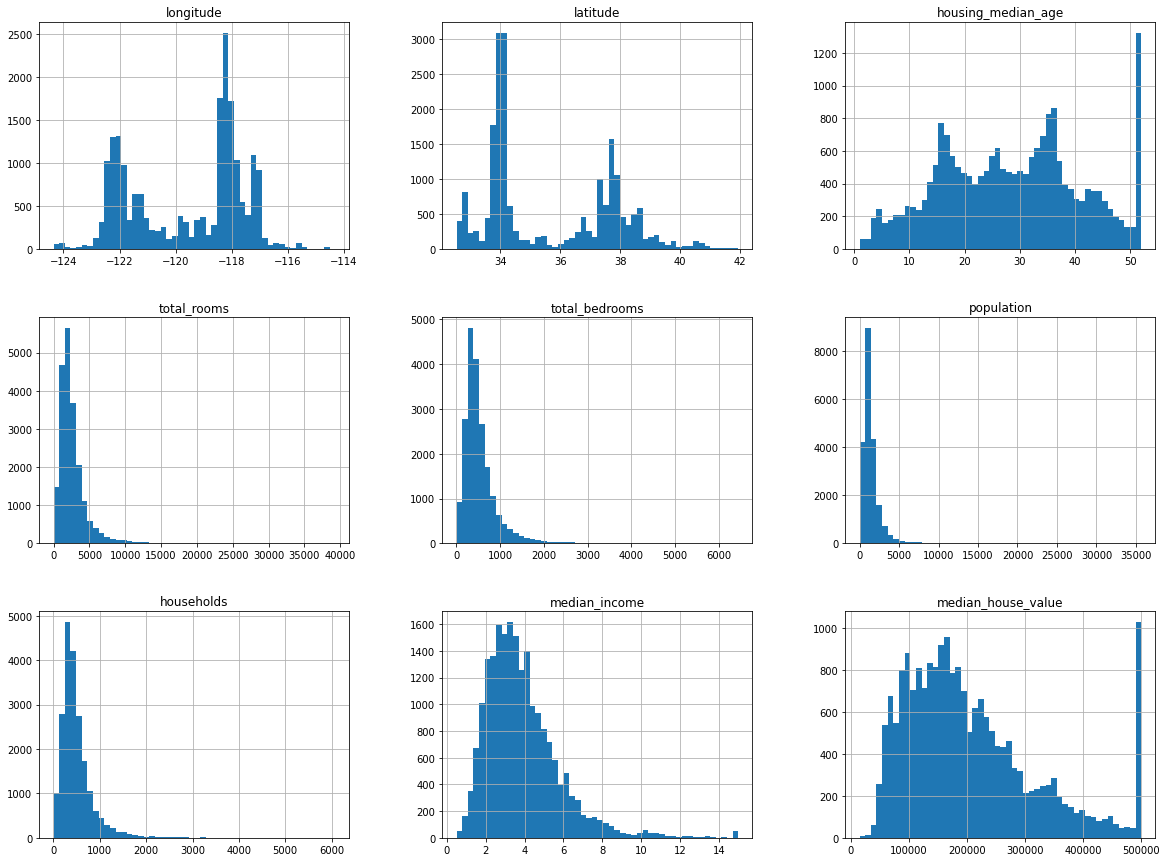

In [5]:
housing.hist(figsize = (20,15), bins = 50)
plt.show()

<AxesSubplot:>

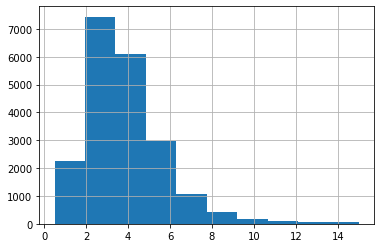

In [6]:
#Take the median income as the feature

housing['median_income'].hist()

In [7]:
#Create housing income category
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
#Categorize the data to 5 categories
housing['income_cat'].where(housing['income_cat']< 5, other = 5.0,inplace = True)
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [8]:
housing['income_cat'].value_counts()/ len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [9]:
#Introduce the shuffling samples to train and test
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2,random_state = 29)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: income_cat, dtype: float64

In [11]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114462
1.0    0.039789
Name: income_cat, dtype: float64

**** samples proportion mainteined via stratified sampling ****
why statified? Because feature space are less and minimize the possibility to missed out any class within the midsize datasets. 

In [12]:
# Compare different sampling method

train_set,test_set = train_test_split(housing, test_size = 0.2,random_state = 29)

In [13]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

Comparing_props = pd.DataFrame({
"Overall_proportions": income_cat_proportions(housing),
"Random_Sampling": income_cat_proportions(test_set),
"Stratified_Sampling": income_cat_proportions(strat_test_set)}).sort_index()

In [14]:
Comparing_props

,Overall_proportions,Random_Sampling,Stratified_Sampling
1.0,0.039826,0.042636,0.039971
2.0,0.318847,0.311531,0.318798
3.0,0.350581,0.344719,0.350533
4.0,0.176308,0.181686,0.176357
5.0,0.114438,0.119428,0.114341


In [15]:
#Compute error percentages

Comparing_props["Random %error"]= 100*Comparing_props["Random_Sampling"]/Comparing_props["Overall_proportions"] -100
Comparing_props["Strat. %error"]= 100*Comparing_props["Stratified_Sampling"]/Comparing_props["Overall_proportions"] -100
Comparing_props

,Overall_proportions,Random_Sampling,Stratified_Sampling,Random %error,Strat. %error
1.0,0.039826,0.042636,0.039971,7.055961,0.364964
2.0,0.318847,0.311531,0.318798,-2.294484,-0.015195
3.0,0.350581,0.344719,0.350533,-1.672195,-0.013820
4.0,0.176308,0.181686,0.176357,3.050289,0.027480
5.0,0.114438,0.119428,0.114341,4.360711,-0.084674


In [16]:
#for items in (strat_train_set,strat_test_set):
   # items.drop('income_cat',axis =1, inplace=True)

In [17]:
housing_train = strat_train_set.copy()

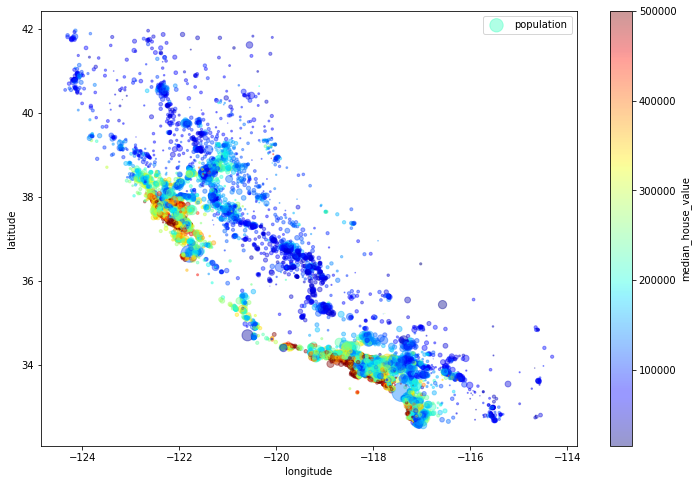

In [18]:
housing_train.plot(kind="scatter", y= 'latitude',x='longitude',alpha = 0.4, s=housing_train['population']/100,label='population',
                  figsize = (12,8),c='median_house_value', cmap=plt.get_cmap("jet"),sharex=False)
plt.legend()
plt.show()

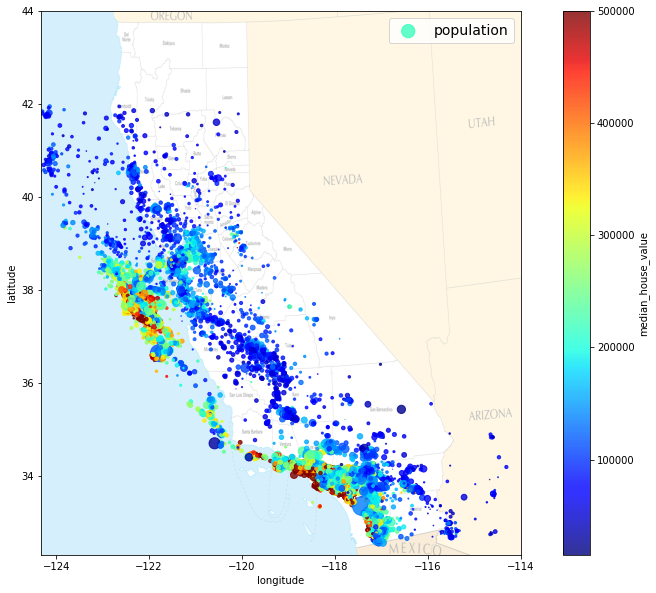

In [19]:
import matplotlib.image as mpimg

ax= housing_train.plot(kind="scatter", y= 'latitude',x='longitude',alpha = 0.8, s=housing_train['population']/100,label='population',
                  figsize = (15,10),c='median_house_value', cmap=plt.get_cmap("jet"),sharex=False)

#Load image
california_img = mpimg.imread('../input/california-png/california_county_map.png')

plt.imshow(california_img,extent = [-124.33,-114,32.3,44],alpha = 0.5,cmap=plt.get_cmap("jet"))

plt.legend(fontsize=14)
plt.show()

## Corelation Anlaysis

In [20]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Identify feature attributes

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

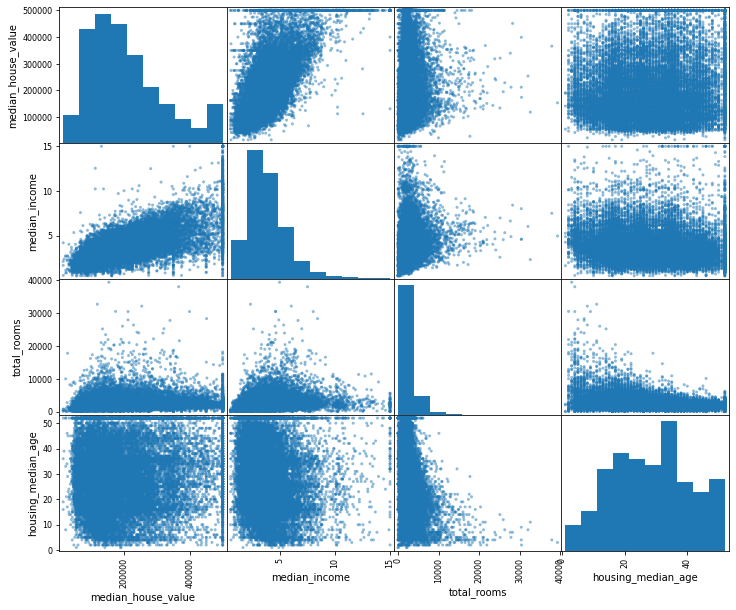

In [21]:
imp_attributes = ["median_house_value","median_income","total_rooms", "housing_median_age"]
from pandas.plotting import scatter_matrix
scatter_matrix (housing[imp_attributes],figsize = (12,10))

(0.0, 16.0, 0.0, 550000.0)

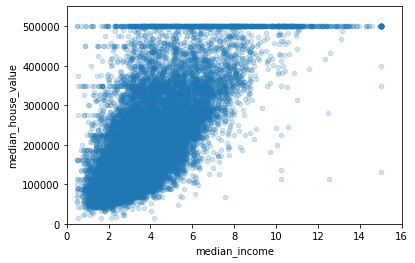

In [22]:
#Zoom in to median house value
housing.plot(kind='scatter',y="median_house_value",x='median_income',alpha = 0.2)
plt.axis([0,16,0,550000])

# Feature Engineering

In [23]:
housing['bedroom_per_house'] = housing["total_bedrooms"]/ housing['total_rooms']
housing['population_per_household']= housing['population']/housing['households']
housing['rooms per household']= housing['total_rooms']/ housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms per household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedroom_per_house          -0.255880
Name: median_house_value, dtype: float64

In [24]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,bedroom_per_house,population_per_household,rooms per household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,3.006686,0.213039,3.070655,5.429000
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,1.054618,0.057983,10.386050,2.474173
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.000000,0.100000,0.692308,0.846154
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,2.000000,0.175427,2.429741,4.440716
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,3.000000,0.203162,2.818116,5.229129
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,4.000000,0.239821,3.282261,6.052381
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,5.000000,1.000000,1243.333333,141.909091


# Prepare datasets for ML

In [25]:
housing = strat_train_set.drop('median_house_value',axis = 1)
housing_label = strat_train_set['median_house_value'].copy()

In [26]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 8007 to 230
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16349 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
 9   income_cat          16512 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [27]:
#impute Null with median value
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
median = housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median,inplace = True)

sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
12809,-121.47,38.61,31.0,1072.0,433.0,781.0,281.0,1.6563,INLAND,2.0
10236,-117.92,33.87,33.0,1597.0,433.0,1888.0,423.0,3.0550,<1H OCEAN,3.0
4309,-118.32,34.09,44.0,2666.0,433.0,2297.0,726.0,1.6760,<1H OCEAN,2.0
3921,-118.56,34.20,35.0,2273.0,433.0,1431.0,403.0,4.0789,<1H OCEAN,3.0
16879,-122.39,37.60,34.0,707.0,433.0,381.0,156.0,4.3750,NEAR OCEAN,3.0


In [28]:
#Using sKLEARN imputer